In [314]:
import os
from copy import deepcopy
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms
from PIL import Image
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


%load_ext tensorboard
DATASET_PATH = "imagewang"
CHECKPOINT_PATH = "saved_models/"
NUM_WORKERS = os.cpu_count()

pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/var/folders/rc/qnb2qyw56klbf0h05cd980880000gn/T/ipykernel_1094/764774526.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')
Global seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Data Augmentation for Contrastive Learning

In [326]:
class Transformer(object):
    def __call__(self, x):
        return [transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomResizedCrop(size=96),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)],p=0.8),
        transforms.RandomGrayscale(p=0.2),transforms.GaussianBlur(kernel_size=9),transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])(x) for i in range(2)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 10000x5000 with 0 Axes>

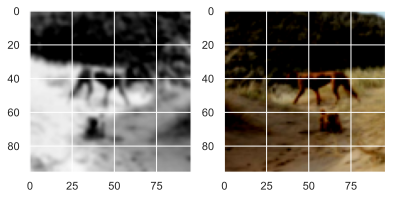

In [327]:
# Load and transform the image
img = Image.open(f'{DATASET_PATH}/unsup/ILSVRC2012_val_00000948.JPEG')
img = img.resize((224, 224))

conv1 = Transformer()
ims  = conv1(img)

plt.figure(figsize=(100,50))
fig, axes = plt.subplots(1,2)
axes[0].imshow(np.transpose(ims[0], (1, 2, 0)))
axes[1].imshow(np.transpose(ims[1], (1, 2, 0)))
plt.show()

In [309]:
class SimCLR(pl.LightningModule):
    
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        feats = self.convnet(imgs) # --- <<-- like using cnn
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())
        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')


In [329]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True, transform=Transformer(contrast_transforms, n_views=2))
        train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True, transform=Transformer(contrast_transforms, n_views=2))
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
                                        drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
                                      drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        print(trainer.checkpoint_callback.best_model_path)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
    return model

In [330]:
simclr_model = train_simclr(batch_size=256,hidden_dim=128,lr=5e-4,temperature=0.07,weight_decay=1e-4,max_epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file saved_models/SimCLR.ckpt`


In [268]:
%tensorboard --logdir saved_models/ --port=6069

Reusing TensorBoard on port 6069 (pid 11420), started 6:15:08 ago. (Use '!kill 11420' to kill it.)

Contrastive learning benefits a lot from long training, training the model for even longer might reduce its loss further. And, contrastive learning can also benefit from using larger models, if sufficient unlabeled data is available. Meaning, the more unlabled data we have the mode self-supervised training we perform on the model.

After performing the contrastive training(learning) and saving the data to out local folder, we can deploy it on downstream tasks to see the performance of the model with little labeled data.

Note: 
1. We might expect our model to perform well with even small labeled data since it has learned the generalized representation.
2. Our model has learned a generalized model and we have very few parameters that are trained. so using the labeled data for fine-tuning with downstream tasks can not create overfitting.


The most common downstream task is Logistic Regression, we are going to use it for testing

In [269]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

### Load our training and validation data from training_1, and testing_1 folder for the logistic regression

In [367]:
img_transforms = transforms.Compose([transforms.Resize((96, 96)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_img_data = torchvision.datasets.ImageFolder(root=DATASET_PATH+"/training_1", transform=img_transforms)
test_img_data = torchvision.datasets.ImageFolder(root=DATASET_PATH+"/testing_1", transform=img_transforms)

In [356]:
test_img_data[0][0].shape
torchvision.utils.save_image(test_img_data[0][0],f"{DATASET_PATH}/testing_1/{test_img_data[0][1]}/{i}.JPEG", normalize=True)

Our model has two parts. ResNet-18(a convolutional neural network architecture that consists of multiple convolutional layer) followed by model.fc (fully connected), fully connected layer which is responsible for generating the final output predictions of the network.

Now, we will get a deep copy of our model to not update our model when performing finee-tuning. and, remove the fully connected newral network sequence from out copied model by setting it to Identity matrix.

In [361]:
@torch.no_grad()
def prepare_data_features(model, dataset, test=False):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # removing the fully connected network by repplacing network.fc with identity function nn.Identity()
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=test, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

#### Preparing the images of training and testing to use 

In [362]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data, test=True)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [299]:
test_feats_simclr[:5][0].shape
print(type(test_feats_simclr[:5][0]))

<class 'torch.Tensor'>


In [363]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [364]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors]
    )
    return new_dataset

In [401]:

results = {}
final_model = None
for num_imgs_per_label in [50, 100, 200, 500, 1000]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    final_model, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=10,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file saved_models/LogisticRegression_50.ckpt`
/Users/samuaelad/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/samuaelad/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number 

Found pretrained model at saved_models/LogisticRegression_50.ckpt, loading...
Found pretrained model at saved_models/LogisticRegression_100.ckpt, loading...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file saved_models/LogisticRegression_200.ckpt`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file saved_models/LogisticRegression_500.ckpt`


Found pretrained model at saved_models/LogisticRegression_200.ckpt, loading...
Found pretrained model at saved_models/LogisticRegression_500.ckpt, loading...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
/Users/samuaelad/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/samuaelad/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataload

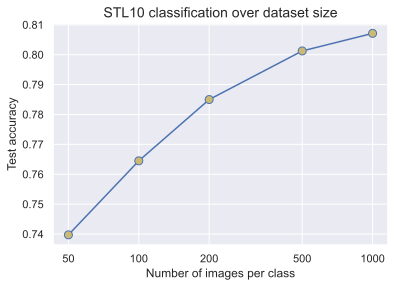

Test accuracy for  50 images per label: 73.98%
Test accuracy for 100 images per label: 76.45%
Test accuracy for 200 images per label: 78.50%
Test accuracy for 500 images per label: 80.12%
Test accuracy for 1000 images per label: 80.71%


In [402]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores,marker=".", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


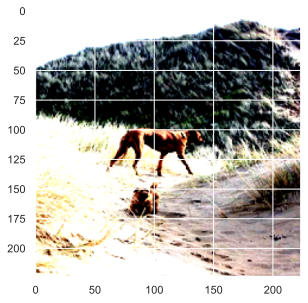

In [403]:
# Load and resize the image
img = Image.open(f'{DATASET_PATH}/unsup/ILSVRC2012_val_00000948.JPEG')
img = img.resize((224, 224))

# Convert to a tensor
transform = transforms.Compose([    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
img = transform(img)
print(img.shape)

plt.imshow(np.transpose(img, (1, 2, 0)))

In [404]:
network = deepcopy(simclr_model.convnet)
network.fc = nn.Identity()  # removing the fully connected network by repplacing network.fc with identity function nn.Identity()
network.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512]) <class 'torch.Tensor'>
torch.Size([1, 512]) torch.Size([3, 224, 224]) (224, 224, 3)


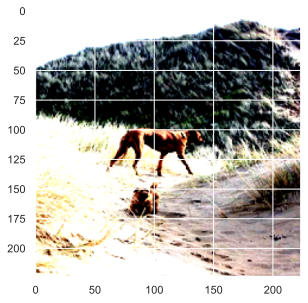

In [409]:
# Pass the image through the model
# resnet10 = network(pretrained=True)
with torch.no_grad():
    output = network(img.unsqueeze(0))
    
print(output.shape, type(output))
print(output.shape, img.shape, np.transpose(img.numpy(), (1, 2, 0)).shape )
plt.imshow( np.transpose(img.numpy(), (1, 2, 0)))
# torchvision.util.save_image(img, "image.jpeg")
# Convert the output tensor back to an image
output = output.squeeze(0)
# output = output.permute(1, 2, 0)
output = output.detach().numpy()


In [406]:
output = ((output - output.min()) / (output.max() - output.min())) * 255
output = output.astype(np.uint8)
output = Image.fromarray(output)

In [407]:
print(type(output), output)

<class 'PIL.Image.Image'> <PIL.Image.Image image mode=L size=1x512 at 0x7F9BE10BCA30>


In [408]:
output.save('updated_image.jpg')